# NYC Yellow Taxi preprocessing notebook
This notebook preprocesses the NYC Yellow taxi data from 2018-2019. The preprocessing removes faulty data and outliers and aggregates the taxi logs into hourly per zone aggregates of pickups and dropoffs. The notebook creates two datasets:
* A two year dataset of the data from january 2018 to december 2019
* A 10 months dataset of the 10 first months of 2018. This dataset is used in the paper.

The Notebook also creates the necessary priors matrices for the NRI and preprocesses the weather data using the package Meteostat

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt


In [3]:
import sys
dataset_folder = f'../../datafolder/rawdata/taxi'
shapefile_folder = f'{dataset_folder}/shapefiles'
proc_data_folder = f'../../datafolder/procdata/taxi_data/full_manhattan' # Full manhattan because previous experiments used a subset of zones.
sys.path.append('../') # Change this for the path to your folder, however this should work

from GraphTrafficLib.utils.data_preprocess import preprocess_NYC_borough_dropoff, preprocess_NYC_borough_pickup
from GraphTrafficLib.utils.adjacancy_matrix_generators import dtw_adj_generator, get_local_adj_matrix

### Load metadata

In [4]:
NYC_shapefile = f'{shapefile_folder}/taxi_zones.shp'
shp = gpd.read_file(NYC_shapefile)
manhattan_ids = shp.loc[shp.borough == "Manhattan"].LocationID
EWR_ids = shp.loc[shp.borough == "EWR"].LocationID # Small airport area with 1 zone
queens_ids = shp.loc[shp.borough == "Queens"].LocationID
bronx_ids = shp.loc[shp.borough == "Bronx"].LocationID
brooklyn_ids = shp.loc[shp.borough == "Brooklyn"].LocationID
staten_ids = shp.loc[shp.borough == "Staten Island"].LocationID

In [5]:
# Some hardcoded clean up of weird zones
manhattan_ids = manhattan_ids.loc[manhattan_ids != 103]
queens_ids = queens_ids.loc[(queens_ids != 30) & (queens_ids != 2) & (queens_ids != 27)].unique()
bronx_ids = bronx_ids.loc[(bronx_ids != 199)].unique()

### Data file strings and load dtype settings

In [6]:
# 2018 data files
NYC_2018_filenames = [f"yellow_tripdata_2018-0{i}.csv" for i in range(1,10)]
NYC_2018_filenames2 = [f"yellow_tripdata_2018-{i}.csv" for i in range(10,13)]
NYC_2018_filenames = NYC_2018_filenames + NYC_2018_filenames2
file_paths_2018 = [f'{dataset_folder}/2018/{filename}' for filename in NYC_2018_filenames]

# 2019 data files
NYC_filenames = [f"yellow_tripdata_2019-0{i}.csv" for i in range(1,10)]
NYC_filenames2 = [f"yellow_tripdata_2019-{i}.csv" for i in range(10,13)]
NYC_filenames = NYC_filenames + NYC_filenames2
file_paths_2019 = [f'{dataset_folder}/2019/{filename}' for filename in NYC_filenames]

file_paths = file_paths_2018 + file_paths_2019

In [7]:
# As we do not need the precision of 64 bits we change the precision to 32 bits for all numerical columns
important_cols = ["tpep_pickup_datetime", "tpep_dropoff_datetime", "trip_distance", "PULocationID", "DOLocationID", "fare_amount"]
df_test = pd.read_csv(file_paths[0], nrows=100, usecols=important_cols)

float_cols = [c for c in df_test if df_test[c].dtype == "float64"]
float32_cols = {c: np.float32 for c in float_cols}

int_cols = [c for c in df_test if df_test[c].dtype == "int64"]
int32_cols = {c: np.int32 for c in int_cols}

dtype_cols = {**int32_cols, **float32_cols}

## Preprocess data for full 2 year dataset

In [8]:
pickup_2019, full_time_list_2019 = preprocess_NYC_borough_pickup(file_paths=file_paths_2019, location_ids=manhattan_ids)

../../datafolder/rawdata/taxi/2019/yellow_tripdata_2019-01.csv done, added (66, 744) to df
../../datafolder/rawdata/taxi/2019/yellow_tripdata_2019-02.csv done, added (66, 672) to df
../../datafolder/rawdata/taxi/2019/yellow_tripdata_2019-03.csv done, added (66, 744) to df
../../datafolder/rawdata/taxi/2019/yellow_tripdata_2019-04.csv done, added (66, 720) to df
../../datafolder/rawdata/taxi/2019/yellow_tripdata_2019-05.csv done, added (66, 744) to df
../../datafolder/rawdata/taxi/2019/yellow_tripdata_2019-06.csv done, added (66, 720) to df
../../datafolder/rawdata/taxi/2019/yellow_tripdata_2019-07.csv done, added (66, 744) to df
../../datafolder/rawdata/taxi/2019/yellow_tripdata_2019-08.csv done, added (66, 744) to df
../../datafolder/rawdata/taxi/2019/yellow_tripdata_2019-09.csv done, added (66, 720) to df
../../datafolder/rawdata/taxi/2019/yellow_tripdata_2019-10.csv done, added (66, 744) to df
../../datafolder/rawdata/taxi/2019/yellow_tripdata_2019-11.csv done, added (66, 720) to df

In [9]:
dropoff_2019, full_time_list_2019 = preprocess_NYC_borough_dropoff(file_paths=file_paths_2019, location_ids=manhattan_ids)

../../datafolder/rawdata/taxi/2019/yellow_tripdata_2019-01.csv done, added (66, 744) to df
../../datafolder/rawdata/taxi/2019/yellow_tripdata_2019-02.csv done, added (66, 672) to df
../../datafolder/rawdata/taxi/2019/yellow_tripdata_2019-03.csv done, added (66, 744) to df
../../datafolder/rawdata/taxi/2019/yellow_tripdata_2019-04.csv done, added (66, 720) to df
../../datafolder/rawdata/taxi/2019/yellow_tripdata_2019-05.csv done, added (66, 744) to df
../../datafolder/rawdata/taxi/2019/yellow_tripdata_2019-06.csv done, added (66, 720) to df
../../datafolder/rawdata/taxi/2019/yellow_tripdata_2019-07.csv done, added (66, 744) to df
../../datafolder/rawdata/taxi/2019/yellow_tripdata_2019-08.csv done, added (66, 744) to df
../../datafolder/rawdata/taxi/2019/yellow_tripdata_2019-09.csv done, added (66, 720) to df
../../datafolder/rawdata/taxi/2019/yellow_tripdata_2019-10.csv done, added (66, 744) to df
../../datafolder/rawdata/taxi/2019/yellow_tripdata_2019-11.csv done, added (66, 720) to df

In [10]:
full_data_2019 = np.stack([pickup_2019, dropoff_2019], axis=-1)

In [11]:
pickup_2018, full_time_list_2018 = preprocess_NYC_borough_pickup(file_paths=file_paths_2018, location_ids=manhattan_ids, year=2018)

../../datafolder/rawdata/taxi/2018/yellow_tripdata_2018-01.csv done, added (66, 744) to df
../../datafolder/rawdata/taxi/2018/yellow_tripdata_2018-02.csv done, added (66, 672) to df
../../datafolder/rawdata/taxi/2018/yellow_tripdata_2018-03.csv done, added (66, 744) to df
../../datafolder/rawdata/taxi/2018/yellow_tripdata_2018-04.csv done, added (66, 720) to df
../../datafolder/rawdata/taxi/2018/yellow_tripdata_2018-05.csv done, added (66, 744) to df
../../datafolder/rawdata/taxi/2018/yellow_tripdata_2018-06.csv done, added (66, 720) to df
../../datafolder/rawdata/taxi/2018/yellow_tripdata_2018-07.csv done, added (66, 744) to df
../../datafolder/rawdata/taxi/2018/yellow_tripdata_2018-08.csv done, added (66, 744) to df
../../datafolder/rawdata/taxi/2018/yellow_tripdata_2018-09.csv done, added (66, 720) to df
../../datafolder/rawdata/taxi/2018/yellow_tripdata_2018-10.csv done, added (66, 744) to df
../../datafolder/rawdata/taxi/2018/yellow_tripdata_2018-11.csv done, added (66, 720) to df

In [12]:
dropoff_2018, full_time_list_2018 = preprocess_NYC_borough_dropoff(file_paths=file_paths_2018, location_ids=manhattan_ids, year=2018)

../../datafolder/rawdata/taxi/2018/yellow_tripdata_2018-01.csv done, added (66, 744) to df
../../datafolder/rawdata/taxi/2018/yellow_tripdata_2018-02.csv done, added (66, 672) to df
../../datafolder/rawdata/taxi/2018/yellow_tripdata_2018-03.csv done, added (66, 744) to df
../../datafolder/rawdata/taxi/2018/yellow_tripdata_2018-04.csv done, added (66, 720) to df
../../datafolder/rawdata/taxi/2018/yellow_tripdata_2018-05.csv done, added (66, 744) to df
../../datafolder/rawdata/taxi/2018/yellow_tripdata_2018-06.csv done, added (66, 720) to df
../../datafolder/rawdata/taxi/2018/yellow_tripdata_2018-07.csv done, added (66, 744) to df
../../datafolder/rawdata/taxi/2018/yellow_tripdata_2018-08.csv done, added (66, 744) to df
../../datafolder/rawdata/taxi/2018/yellow_tripdata_2018-09.csv done, added (66, 720) to df
../../datafolder/rawdata/taxi/2018/yellow_tripdata_2018-10.csv done, added (66, 744) to df
../../datafolder/rawdata/taxi/2018/yellow_tripdata_2018-11.csv done, added (66, 720) to df

In [13]:
# collect the data
full_data_2018 = np.stack([pickup_2018, dropoff_2018], axis=-1)
full_data = np.concatenate([full_data_2018, full_data_2019], 1)
full_time_list = full_time_list_2018.union(full_time_list_2019)

In [14]:
# Save the data

np.save(f'{proc_data_folder}/twoyear_full_manhattan_2d.npy', full_data)
np.save(f'{proc_data_folder}/twoyear_time_list.npy', full_time_list)

# Dataset without november and december

In [15]:
short_2019 = file_paths_2019[:10]

In [16]:
pickup_short_2019, short_time_list_2019 = preprocess_NYC_borough_pickup(file_paths=short_2019, location_ids=manhattan_ids)

../../datafolder/rawdata/taxi/2019/yellow_tripdata_2019-01.csv done, added (66, 744) to df
../../datafolder/rawdata/taxi/2019/yellow_tripdata_2019-02.csv done, added (66, 672) to df
../../datafolder/rawdata/taxi/2019/yellow_tripdata_2019-03.csv done, added (66, 744) to df
../../datafolder/rawdata/taxi/2019/yellow_tripdata_2019-04.csv done, added (66, 720) to df
../../datafolder/rawdata/taxi/2019/yellow_tripdata_2019-05.csv done, added (66, 744) to df
../../datafolder/rawdata/taxi/2019/yellow_tripdata_2019-06.csv done, added (66, 720) to df
../../datafolder/rawdata/taxi/2019/yellow_tripdata_2019-07.csv done, added (66, 744) to df
../../datafolder/rawdata/taxi/2019/yellow_tripdata_2019-08.csv done, added (66, 744) to df
../../datafolder/rawdata/taxi/2019/yellow_tripdata_2019-09.csv done, added (66, 720) to df
../../datafolder/rawdata/taxi/2019/yellow_tripdata_2019-10.csv done, added (66, 744) to df


In [17]:
dropoff_short_2019, short_time_list_2019 = preprocess_NYC_borough_dropoff(file_paths=short_2019, location_ids=manhattan_ids)

../../datafolder/rawdata/taxi/2019/yellow_tripdata_2019-01.csv done, added (66, 744) to df
../../datafolder/rawdata/taxi/2019/yellow_tripdata_2019-02.csv done, added (66, 672) to df
../../datafolder/rawdata/taxi/2019/yellow_tripdata_2019-03.csv done, added (66, 744) to df
../../datafolder/rawdata/taxi/2019/yellow_tripdata_2019-04.csv done, added (66, 720) to df
../../datafolder/rawdata/taxi/2019/yellow_tripdata_2019-05.csv done, added (66, 744) to df
../../datafolder/rawdata/taxi/2019/yellow_tripdata_2019-06.csv done, added (66, 720) to df
../../datafolder/rawdata/taxi/2019/yellow_tripdata_2019-07.csv done, added (66, 744) to df
../../datafolder/rawdata/taxi/2019/yellow_tripdata_2019-08.csv done, added (66, 744) to df
../../datafolder/rawdata/taxi/2019/yellow_tripdata_2019-09.csv done, added (66, 720) to df
../../datafolder/rawdata/taxi/2019/yellow_tripdata_2019-10.csv done, added (66, 744) to df


In [18]:
short_data_2019 = np.stack([pickup_short_2019, dropoff_short_2019], axis=-1)

In [19]:
# Save the data
np.save(f'{proc_data_folder}/short_year_full_manhattan_2d.npy', short_data_2019)


In [14]:
import h5py

In [28]:
# Creating H5 version for CGC baseline

hf = h5py.File(f'{proc_data_folder}/taxishort_data.h5', 'w')
hf.create_dataset('taxishort_drop', data=dropoff_short_2019.T)
hf.create_dataset('taxishort_pick', data=pickup_short_2019.T)
hf.close()

# Short dataset of only 1 month

In [8]:
# Only use 1 month for the low data volume experiment
month_2019 = file_paths_2019[0:1]

In [9]:
pickup_month_2019, month_time_list_2019 = preprocess_NYC_borough_pickup(file_paths=month_2019, location_ids=manhattan_ids)

../../datafolder/rawdata/taxi/2019/yellow_tripdata_2019-01.csv done, added (66, 744) to df


In [10]:
dropoff_month_2019, month_time_list_2019 = preprocess_NYC_borough_dropoff(file_paths=month_2019, location_ids=manhattan_ids)

../../datafolder/rawdata/taxi/2019/yellow_tripdata_2019-01.csv done, added (66, 744) to df


In [11]:
month_data_2019 = np.stack([pickup_month_2019, dropoff_month_2019], axis=-1)

In [12]:
# Save the data
np.save(f'{proc_data_folder}/month_full_manhattan_2d.npy', month_data_2019)


In [15]:
# Creating H5 version for CGC baseline

hf = h5py.File(f'{proc_data_folder}/taximonth_data.h5', 'w')
hf.create_dataset('taximonth_drop', data=dropoff_month_2019.T)
hf.create_dataset('taximonth_pick', data=pickup_month_2019.T)
hf.close()

# Evenshorter dataset of only 2 weeks

### DTW Adj

#### Short year version

In [20]:
# Make DTW adj for prior
train_steps = int(0.8 * short_data_2019.shape[1])
dtw_adj = dtw_adj_generator(short_data_2019, train_steps)

NameError: name 'short_data_2019' is not defined

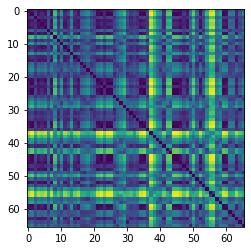

In [51]:
plt.imshow(dtw_adj)

In [52]:
pickle_path_full_manhattan_short_year_dtw_adj = f"{proc_data_folder}/short_year_train_full_manhattan_dtw_adj.npy"
np.save(pickle_path_full_manhattan_short_year_dtw_adj, dtw_adj)

In [53]:
# Discretize the DTW adj for fixed adj graph
dtw_adj_bin = dtw_adj > np.quantile(dtw_adj, 0.9)

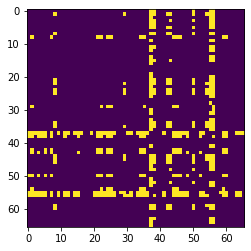

In [54]:
plt.imshow(dtw_adj_bin)

In [55]:
pickle_path_full_manhattan_short_year_dtw_adj_bin = f"{proc_data_folder}/short_year_train_full_manhattan_dtw_adj_bin.npy"
np.save(pickle_path_full_manhattan_short_year_dtw_adj_bin, dtw_adj_bin)

#### month version

In [21]:
# Make DTW adj for prior
train_steps = int(0.8 * month_data_2019.shape[1])
month_dtw_adj = dtw_adj_generator(month_data_2019, train_steps)

100%|███████████████████████████████████████████████████████████████████| 66/66 [00:18<00:00,  3.64it/s]


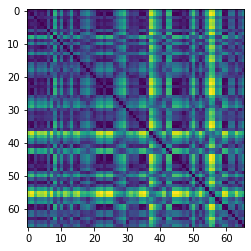

In [22]:
plt.imshow(month_dtw_adj)

In [23]:
pickle_path_full_manhattan_month_dtw_adj = f"{proc_data_folder}/month_train_full_manhattan_dtw_adj.npy"
np.save(pickle_path_full_manhattan_month_dtw_adj, month_dtw_adj)

In [24]:
# Discretize the DTW adj for fixed adj graph
month_dtw_adj_bin = month_dtw_adj > np.quantile(month_dtw_adj, 0.9)

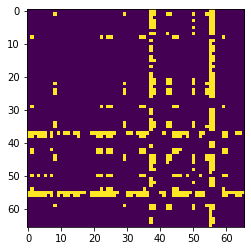

In [25]:
plt.imshow(month_dtw_adj_bin)

In [26]:
pickle_path_full_manhattan_month_dtw_adj_bin = f"{proc_data_folder}/month_train_full_manhattan_dtw_adj_bin.npy"
np.save(pickle_path_full_manhattan_month_dtw_adj_bin, month_dtw_adj_bin)

#### Week vers

In [28]:
# Make DTW adj for prior
train_steps = int(0.24 * month_data_2019.shape[1])
week_dtw_adj = dtw_adj_generator(month_data_2019, train_steps)

100%|███████████████████████████████████████████████████████████████████| 66/66 [00:05<00:00, 11.91it/s]


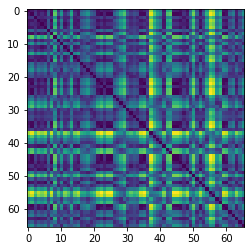

In [29]:
plt.imshow(week_dtw_adj)

In [30]:
pickle_path_full_manhattan_week_dtw_adj = f"{proc_data_folder}/week_train_full_manhattan_dtw_adj.npy"
np.save(pickle_path_full_manhattan_week_dtw_adj, week_dtw_adj)

In [31]:
# Discretize the DTW adj for fixed adj graph
week_dtw_adj_bin = week_dtw_adj > np.quantile(week_dtw_adj, 0.9)

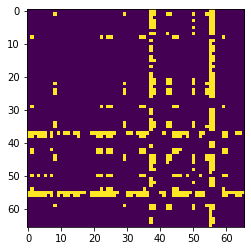

In [32]:
plt.imshow(month_dtw_adj_bin)

In [33]:
pickle_path_full_manhattan_week_dtw_adj_bin = f"{proc_data_folder}/week_train_full_manhattan_dtw_adj_bin.npy"
np.save(pickle_path_full_manhattan_week_dtw_adj_bin, week_dtw_adj_bin)

### Local Adj

In [56]:
# Create local adj matrix based on shapefile
manhattan_shp = shp.loc[shp.LocationID.isin(manhattan_ids)]

In [57]:
local_adj = get_local_adj_matrix(manhattan_shp.reset_index(drop=True))

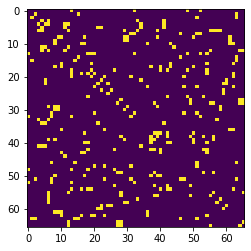

In [58]:
plt.imshow(local_adj)

In [59]:
pickle_path_full_manhattan_full_year_local_adj = f"{proc_data_folder}/full_year_full_manhattan_local_adj"
np.save(pickle_path_full_manhattan_full_year_local_adj, local_adj)

## Empty adj

In [60]:
# Create empty adj
n_nodes = len(manhattan_shp)
empty_adj = np.zeros([n_nodes, n_nodes])

In [61]:
empty_adj

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

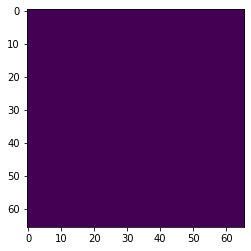

In [62]:
plt.imshow(empty_adj)

In [63]:
np.save(f"{proc_data_folder}/empty_adj.npy", empty_adj)

## Full adj

In [64]:
#Create full adj
full_adj = np.ones([n_nodes, n_nodes]) - np.eye(n_nodes)

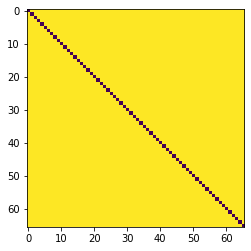

In [65]:
plt.imshow(full_adj)

In [66]:
np.save(f"{proc_data_folder}/full_adj.npy", full_adj)

## Create weather data

In [67]:
import meteostat
from datetime import datetime, timedelta

In [68]:
two_year_data = np.load(f'{proc_data_folder}/twoyear_full_manhattan_2d.npy')

In [69]:
start = datetime(2018, 1, 1)
end = start + timedelta(hours=two_year_data.shape[1])

In [70]:
# IDs of the airports around NYC
LaGuardia = 72503
NewArk = 72502
JFK = 74486

In [80]:
LaGuardiaData = meteostat.Hourly(LaGuardia, start, end)
LaGuardiaData = LaGuardiaData.fetch()[:-1]
LaGuardiaData.prcp.interpolate(inplace=True)
LaGuardiaData.prcp.iloc[0] = 0

In [81]:
NewArkData = meteostat.Hourly(NewArk, start, end)
NewArkData = NewArkData.fetch()[:-1]
NewArkData.prcp.interpolate(inplace=True)
NewArkData.prcp.iloc[0] = 0

In [82]:
JFKData = meteostat.Hourly(JFK, start, end)
JFKData = JFKData.fetch()[:-1]
JFKData.prcp.interpolate(inplace=True)
JFKData.prcp.iloc[0] = 0

In [83]:
airport_mean_prcp = (LaGuardiaData.prcp.values + NewArkData.prcp.values + JFKData.prcp.values) / 3
airport_mean_temp = (LaGuardiaData.temp.values + NewArkData.temp.values + JFKData.temp.values) / 3
mean_weather_df = pd.DataFrame(np.array([airport_mean_prcp, airport_mean_temp]).T, columns=["precipDepth", "temperature"])
mean_weather_df = mean_weather_df.set_index(JFKData.index)

<AxesSubplot:xlabel='time'>

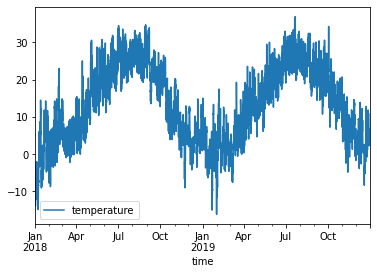

In [84]:
mean_weather_df.plot(y=['temperature'])

<AxesSubplot:xlabel='time'>

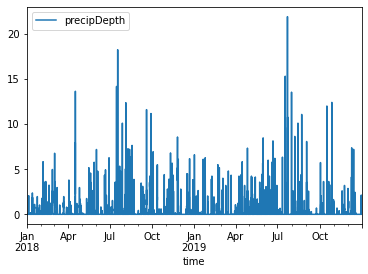

In [85]:
mean_weather_df.plot(y=['precipDepth'])

In [86]:
mean_weather_df.to_csv(f"{proc_data_folder}/../mean_airport_weather.csv")
mean_weather_2019 = mean_weather_df.loc[mean_weather_df.index > datetime(2018, 12, 31, 23)]
mean_weather_2019.to_csv(f"{proc_data_folder}/../mean_airport_weather_2019.csv")